In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from raw_processing import ColumnTransformerPandas

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import SCORERS, balanced_accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn import set_config
from sklearn.pipeline import Pipeline as Pipeline_std


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from performance import plot_roc

# import os
# os.environ['CUDA_VISIBLE_DEVICES']='0' # CPU=-1, GPU:0 = 0, GPU:1 = 1

# from numba import cuda
# cuda.select_device(0) #rm GPU from memory tf/keras
# cuda.close()

/Users/aridmist/opt/anaconda3/envs/tf/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Functions

In [2]:
def plot_learning_curves(history, metric):

    import matplotlib.pyplot as plt
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "b", label="Training loss")
    plt.plot(epochs, val_loss_values, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.clf()
    acc = history_dict[metric]
    val_acc = history_dict[f"val_{metric}"]
    plt.plot(epochs, acc, "b", label="Training acc")
    plt.plot(epochs, val_acc, "r", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


### Put together dataframe to generate dataset

In [3]:
label_scheme = 'labels_2'

pd.options.display.max_columns = None

dataset = pd.read_csv(f'../processed_data/dataset_allfeatures_inc_labels.csv', low_memory=False)
dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
print(dataset[label_scheme].value_counts())

# Features and labels.
X = dataset.iloc[:,14:]
X_cols = X.columns.tolist()
y_names = dataset[label_scheme]
enc = LabelEncoder().fit(y_names)
y = enc.transform(y_names)

# Train, test, validation split.
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full ,test_size=0.1, stratify=y_train_full)

# Display dataset
pd.options.display.max_rows = 10
dataset

dwarf_nova_SU_UMa    630
dwarf_nova_Z_Cam     174
nova_like            144
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
int_polar             49
AMCVn                 46
nova                  46
Name: labels_2, dtype: int64


,oid_ztf,oid_aavso,type_aavso,Eclipsing,CV_Types,CV_subtypes,CV_subsubtypes,eclipse_clear,manual_label,Clarity,labels_1,labels_2,labels_3,labels_4,Amplitude_g,AndersonDarling_g,Autocor_length_g,Beyond1Std_g,CAR_mean_g,CAR_sigma_g,CAR_tau_g,Con_g,Eta_e_g,FluxPercentileRatioMid20_g,FluxPercentileRatioMid35_g,FluxPercentileRatioMid50_g,FluxPercentileRatioMid65_g,FluxPercentileRatioMid80_g,Freq1_harmonics_amplitude_0_g,Freq1_harmonics_amplitude_1_g,Freq1_harmonics_amplitude_2_g,Freq1_harmonics_amplitude_3_g,Freq1_harmonics_rel_phase_1_g,Freq1_harmonics_rel_phase_2_g,Freq1_harmonics_rel_phase_3_g,Freq2_harmonics_amplitude_0_g,Freq2_harmonics_amplitude_1_g,Freq2_harmonics_amplitude_2_g,Freq2_harmonics_amplitude_3_g,Freq2_harmonics_rel_phase_1_g,Freq2_harmonics_rel_phase_2_g,Freq2_harmonics_rel_phase_3_g,Freq3_harmonics_amplitude_0_g,Freq3_harmonics_amplitude_1_g,Freq3_harmonics_amplitude_2_g,Freq3_harmonics_amplitude_3_g,Freq3_harmonics_rel_phase_1_g,Freq3_harmonics_rel_phase_2_g,Freq3_harmonics_rel_phase_3_g,Gskew_g,LinearTrend_g,MaxSlope_g,Mean_g,Meanvariance_g,MedianAbsDev_g,MedianBRP_g,PairSlopeTrend_g,PercentAmplitude_g,PercentDifferenceFluxPercentile_g,PeriodLS_g,Period_fit_g,Psi_CS_g,Psi_eta_g,Q31_g,Rcs_g,Skew_g,SlottedA_length_g,SmallKurtosis_g,Std_g,StetsonK_g,StetsonK_AC_g,StructureFunction_index_21_g,StructureFunction_index_31_g,StructureFunction_index_32_g,Amplitude_r,AndersonDarling_r,Autocor_length_r,Beyond1Std_r,CAR_mean_r,CAR_sigma_r,CAR_tau_r,Con_r,Eta_e_r,FluxPercentileRatioMid20_r,FluxPercentileRatioMid35_r,FluxPercentileRatioMid50_r,FluxPercentileRatioMid65_r,FluxPercentileRatioMid80_r,Freq1_harmonics_amplitude_0_r,Freq1_harmonics_amplitude_1_r,Freq1_harmonics_amplitude_2_r,Freq1_harmonics_amplitude_3_r,Freq1_harmonics_rel_phase_1_r,Freq1_harmonics_rel_phase_2_r,Freq1_harmonics_rel_phase_3_r,Freq2_harmonics_amplitude_0_r,Freq2_harmonics_amplitude_1_r,Freq2_harmonics_amplitude_2_r,Freq2_harmonics_amplitude_3_r,Freq2_harmonics_rel_phase_1_r,Freq2_harmonics_rel_phase_2_r,Freq2_harmonics_rel_phase_3_r,Freq3_harmonics_amplitude_0_r,Freq3_harmonics_amplitude_1_r,Freq3_harmonics_amplitude_2_r,Freq3_harmonics_amplitude_3_r,Freq3_harmonics_rel_phase_1_r,Freq3_harmonics_rel_phase_2_r,Freq3_harmonics_rel_phase_3_r,Gskew_r,LinearTrend_r,MaxSlope_r,Mean_r,Meanvariance_r,MedianAbsDev_r,MedianBRP_r,PairSlopeTrend_r,PercentAmplitude_r,PercentDifferenceFluxPercentile_r,PeriodLS_r,Period_fit_r,Psi_CS_r,Psi_eta_r,Q31_r,Rcs_r,Skew_r,SlottedA_length_r,SmallKurtosis_r,Std_r,StetsonK_r,StetsonK_AC_r,StructureFunction_index_21_r,StructureFunction_index_31_r,StructureFunction_index_32_r,Q31_color,StetsonJ,StetsonL,median_g,min_mag_g,max_mag_g,n_obs_g,dif_min_mean_g,dif_min_median_g,dif_max_mean_g,dif_max_median_g,dif_max_min_g,temporal_baseline_g,kurtosis_g,pwr_max_g,freq_pwr_max_g,FalseAlarm_prob_g,pwr_maxovermean_g,npeaks_pt5to1_g,rrate_pt5to1_g,drate_pt5to1_g,amp_pt5to1_g,npeaks_1to2_g,rrate_1to2_g,drate_1to2_g,amp_1to2_g,npeaks_2to5_g,rrate_2to5_g,drate_2to5_g,amp_2to5_g,npeaks_above5_g,rrate_above5_g,drate_above5_g,amp_above5_g,rollstd_ratio_t20s10_g,stdstilllev_t20s10_g,rollstd_ratio_t10s5_g,stdstilllev_t10s5g,pnts_leq_rollMedWin20-1mag_g,pnts_leq_rollMedWin20-2mag_g,pnts_leq_rollMedWin20-5mag_g,pnts_geq_rollMedWin20+1mag_g,pnts_geq_rollMedWin20+2mag_g,pnts_geq_rollMedWin20+3mag_g,pnts_leq_median-1mag_g,pnts_leq_median-2mag_g,pnts_leq_median-5mag_g,pnts_geq_median+1mag_g,pnts_geq_median+2mag_g,pnts_geq_median+3mag_g,median_r,min_mag_r,max_mag_r,n_obs_r,dif_min_mean_r,dif_min_median_r,dif_max_mean_r,dif_max_median_r,dif_max_min_r,temporal_baseline_r,kurtosis_r,pwr_max_r,freq_pwr_max_r,FalseAlarm_prob_r,pwr_maxovermean_r,npeaks_pt5to1_r,rrate_pt5to1_r,drate_pt5to1_r,amp_pt5to1_r,npeaks_1to2_r,rrate_1to2_r,drate_1to2_r,amp_1to2_r,npeaks_2to5_r,rrate_2to5_r,drate_2to5_r,amp_2to5_r,npeaks_above5_r,rrate_above5_r,drate_above5_r,amp_above5_r,rollstd_ratio_t20s10_r,stdstilllev_t20s10_r,rollstd_ratio_t10s5_r,stdstilllev_t10s5r,pnts_leq_roll

### Build a preprocessing pipeline

In [5]:
# Classifier to use.
classifierNm= 'NN'
balancing = 'weights' # 'sampling', 'weights'
us_valid = 390
os_valid = 390
us_all = 440
os_all = 440

In [6]:
# Imputation and normalisation functions.
# Using subclassed ColumnTransformerPandas to return a Dataframe with columns instead of just an array (what is usually returned)
impute_simple = ColumnTransformerPandas([
    ('imputer', SimpleImputer(strategy='mean'), X_cols)],
    remainder='passthrough')

impute_KNN = ColumnTransformerPandas([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance'), X_cols)],
    remainder='passthrough')

normalise = ColumnTransformerPandas([
    ('normalise', StandardScaler(), X_cols)], 
    remainder='passthrough')

# Under and oversampling strategies.
def sampling(us, os):
    class_dist_us = {enc.transform(['dwarf_nova_SU_UMa'])[0]:us}

    class_dist_os = {enc.transform(['dwarf_nova_SU_UMa'])[0]:os,
                    enc.transform(['dwarf_nova_Z_Cam'])[0]:os,
                    enc.transform(['dwarf_nova_U_Gem'])[0]:os,
                    enc.transform(['nova_like_VY_Scl'])[0]:os,
                    enc.transform(['polar'])[0]:os,
                    enc.transform(['nova_like'])[0]:os,
                    enc.transform(['nova'])[0]:os,
                    enc.transform(['int_polar'])[0]:os,
                    enc.transform(['AMCVn'])[0]:os
                    }

    undersample = RandomUnderSampler(sampling_strategy=class_dist_us, random_state=1)
    oversample = ADASYN(sampling_strategy=class_dist_os, n_neighbors=5,random_state=1)

    return undersample, oversample

sampled = sampling(us_valid, os_valid)
undersample = sampled[0]
oversample = sampled[1]


# Generate a pipeline to perform the column transformations sequentially.
if balancing == 'weights':
    pipe = Pipeline([
        ('preimpnorm', normalise),
        ('impute', impute_KNN),
        ('us', None),
        ('os', None)
    ])
elif balancing == 'sampling':
    pipe_imp = Pipeline_std([
        ('preimpnorm', normalise),
        ('impute', impute_KNN)
    ])

    pipe_bal = Pipeline([
        ('us', undersample),
        ('os', oversample)
    ])

if balancing == 'weights':
    # Lets display the pipeline to see the processes.
    # with display='diagram', simply use display() to see the diagram
    set_config(display='diagram')
    display(pipe)
    # if desired, set display back to the default
    # set_config(display='text')

    # Get parameters of everything in the pipeline, including ColumnTransformer and classifier functions.
    # Get all keys beginning with 'clf__' to get all the classifier parameters.
    pipe.get_params().keys()
    [k for k in pipe.get_params().keys() if k.startswith('clf__')]

else:
    set_config(display='diagram')
    display(pipe_imp)
    display(pipe_bal)

Pipeline(steps=[('preimpnorm',
                 ColumnTransformerPandas(remainder='passthrough',
                                         transformers=[('normalise',
                                                        StandardScaler(),
                                                        ['Amplitude_g',
                                                         'AndersonDarling_g',
                                                         'Autocor_length_g',
                                                         'Beyond1Std_g',
                                                         'CAR_mean_g',
                                                         'CAR_sigma_g',
                                                         'CAR_tau_g', 'Con_g',
                                                         'Eta_e_g',
                                                         'FluxPercentileRatioMid20_g',
                                                         'FluxPercentileRatioMid35_g',
                                                         'FluxPercentileRatioMid50_g',
                                                         'FluxPercentile...
                                                         'Freq1_harmonics_rel_phase_3_g',
                                                         'Freq2_harmonics_amplitude_0_g',
                                                         'Freq2_harmonics_amplitude_1_g',
                                                         'Freq2_harmonics_amplitude_2_g',
                                                         'Freq2_harmonics_amplitude_3_g',
                                                         'Freq2_harmonics_rel_phase_1_g',
                                                         'Freq2_harmonics_rel_phase_2_g',
                                                         'Freq2_harmonics_rel_phase_3_g',
                                                         'Freq3_harmonics_amplitude_0_g',
                                                         'Freq3_harmonics_amplitude_1_g', ...])])),
                ('us', None), ('os', None)])

### Build, compile, fit and plot model learning curves

In [7]:
if balancing == 'sampling':
    # Process X_train and X_valid.
    X_train_imp = pipe_imp.fit_transform(X_train)
    X_valid_processed = pipe_imp.transform(X_valid)
    X_test_processed = pipe_imp.transform(X_test)

    X_train_processed, y_train_processed_non_ohe = pipe_bal.fit_resample(X_train_imp, y_train)

else:
    # Process X_train and X_valid.
    X_train_processed = pipe.fit_transform(X_train)
    X_valid_processed = pipe.transform(X_valid)
    X_test_processed = pipe.transform(X_test)
    y_train_processed_non_ohe = y_train

print(X_train_processed.shape, X_train.shape)

(906, 256) (906, 256)


In [50]:
def get_model(X_train, learning_rate=0.001,l2=0):
    n_features = len(X_train.columns.to_list())
    # Neural network with Functional API.
    # Define inputs, hidden layers and output layer. Define the shapes of the tensors and activation functions.
    inputs = keras.Input(shape=(n_features,), name="input")
    layer = layers.Dense(512, activation="LeakyReLU", name='Dense_1', kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(inputs) #regularizers.l2(0.1)
    layer = layers.BatchNormalization()(layer)
    # layer = layers.dropout(layer, rate=0.1)
    layer = layers.Dense(512, activation="LeakyReLU", name='Dense_2',kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.Dense(512, activation="LeakyReLU", name='Dense_3',kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.Dense(512, activation="LeakyReLU", name='Dense_4',kernel_regularizer=regularizers.l1_l2(l1=0.00, l2=l2))(layer)
    layer = layers.BatchNormalization()(layer)
    outputs = layers.Dense(9, activation="softmax", name='output')(layer)

    # Instantiate the model with the symbolic tensors.
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), 
        loss="categorical_crossentropy",
        metrics="categorical_accuracy")
    return model


eval_score = []
for i in range(1):

    model = get_model(X_train_processed, learning_rate=1e-4)
    print(model.summary())


    # Compute class weights due to class imbalance.
    # Weighting will be applied to the training set only.
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_processed_non_ohe), y=y_train_processed_non_ohe)
    class_weights_dict = dict(zip(np.unique(y_train_processed_non_ohe), class_weights))
    if balancing == 'weights':
        class_weights_dict = None
    else:
        class_weights_dict = class_weights_dict

    # One hot encode class labels, used for categorical cross-entropy loss function.
    num_classes = len(np.unique(y))
    y_train_processed = to_categorical(y_train_processed_non_ohe, num_classes=num_classes, dtype='float32')
    y_valid_processed = to_categorical(y_valid, num_classes=num_classes, dtype='float32')
    y_test_processed = to_categorical(y_test, num_classes=num_classes, dtype='float32')


    history = model.fit(X_train_processed, 
        y_train_processed, 
        epochs=2000, 
        batch_size=int(X_train_processed.shape[0]/8),
        validation_data=(X_valid_processed,y_valid_processed),
        class_weight=class_weights_dict,
        callbacks= [ModelCheckpoint(f'../results/NNCheckpoint{i}.hdf5',
                                monitor="val_loss", 
                                mode="min",
                                save_best_only=True, 
                                verbose=0)
        ]
        )
    
    plot_learning_curves(history, metric='categorical_accuracy')
    
    evalModel = load_model(f'../results/NNCheckpoint{i}.hdf5')
    eval_y_pred_prob = model.predict(X_test_processed)
    eval_y_pred = np.argmax(eval_y_pred_prob, axis=1)
    eval_y_test_labels = np.argmax(y_test_processed, axis=1)
    eval_score.append(f1_score(y_true=eval_y_test_labels, y_pred=eval_y_pred, average='macro'))


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256)]             0         
                                                                 
 Dense_1 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 Dense_2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_11 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 Dense_3 (Dense)             (None, 512)               262

KeyboardInterrupt: 

0


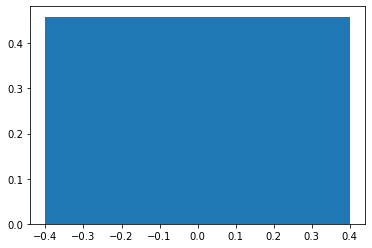

In [40]:
# Get the index of the model with the highest macro f1 score.
plt.bar(range(len(eval_score)), eval_score)
best_model_index = np.argmax(eval_score)
print(best_model_index)


### Use best model to make test set predictions and evaluate.

14/14 [==============================] - 0s 13ms/step
                   precision  recall  f1-score  support
AMCVn                   0.14    0.14      0.14       14
dwarf_nova_SU_UMa       0.83    0.78      0.81      189
dwarf_nova_U_Gem        0.44    0.46      0.45       35
dwarf_nova_Z_Cam        0.59    0.62      0.60       52
int_polar               0.25    0.07      0.11       15
nova                    0.78    0.50      0.61       14
nova_like               0.60    0.67      0.64       43
nova_like_VY_Scl        0.50    0.72      0.59       36
polar                   0.59    0.65      0.62       34
accuracy                0.66    0.66      0.66        0
macro avg               0.53    0.51      0.51      432
weighted avg            0.66    0.66      0.65      432


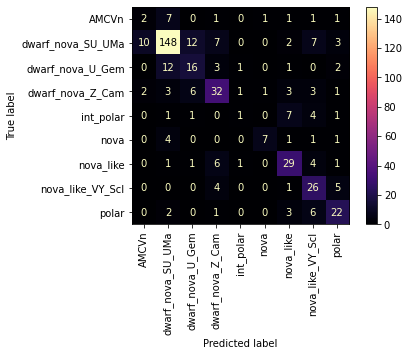

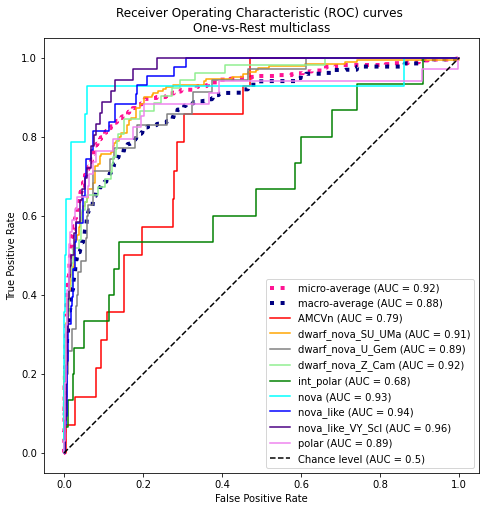

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
test='test'
# Store best parameters and best model in variables.
best_model = load_model(f'../results/NNCheckpoint{best_model_index}.hdf5')

# Collect unique class labels in order of y_test.
class_labels = enc.inverse_transform(np.unique(y_test))

# Make predictions and gather probabilities for applying model to test set.
y_pred_prob = model.predict(X_test_processed)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_processed, axis=1)


# Plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(cm, display_labels=enc.inverse_transform(np.unique(y_train)))
disp.plot(xticks_rotation='vertical', cmap='magma')
disp.figure_.savefig(f'../results/{test}cm_{classifierNm}_{balancing}.pdf', format='pdf', bbox_inches='tight')


# Print and save the classification report
pd.options.display.max_rows=None
cr = classification_report(y_test_labels, y_pred, target_names=enc.inverse_transform(np.unique(y_train)), output_dict=True, zero_division=0)
cr_df = pd.DataFrame(cr).transpose().round({'precision':2, 'recall':2, 'f1-score':2}).astype({'support':'int64'})
cr_df.to_csv(f'../results/{test}cr_{classifierNm}_{balancing}.csv')
print(cr_df)

plot_roc(y_train, y_test_labels, y_pred_prob, enc, path=f'../results/{test}roc_curve_{classifierNm}_{balancing}.pdf')


In [61]:
# save the model and class labels and best parameters using pickle
import pickle
pickle.dump(best_model, open(f'../results/model_{classifierNm}_{balancing}.pkl', 'wb'))
model.save(f'../results/model_{classifierNm}_{balancing}.h5')
pickle.dump(enc, open(f'../results/encoder_{classifierNm}_{balancing}.pkl', 'wb'))
# new_model = tf.keras.models.load_model('my_model.h5')

### Use whole training set

In [ ]:
sampled2 = sampling(us_all, os_all)
undersample = sampled[0]
oversample = sampled[1]


# Generate a pipeline to perform the column transformations sequentially.
if balancing == 'weights':
    pipe = Pipeline([
        ('preimpnorm', normalise),
        ('impute', impute_KNN),
        ('us', None),
        ('os', None)
    ])
elif balancing == 'sampling':
    pipe_imp = Pipeline_std([
        ('preimpnorm', normalise),
        ('impute', impute_KNN)
    ])

    pipe_bal = Pipeline([
        ('us', undersample),
        ('os', oversample)
    ])

# if balancing == 'weights':
#     # Lets display the pipeline to see the processes.
#     # with display='diagram', simply use display() to see the diagram
#     set_config(display='diagram')
#     display(pipe)
#     # if desired, set display back to the default
#     # set_config(display='text')

#     # Get parameters of everything in the pipeline, including ColumnTransformer and classifier functions.
#     # Get all keys beginning with 'clf__' to get all the classifier parameters.
#     pipe.get_params().keys()
#     [k for k in pipe.get_params().keys() if k.startswith('clf__')]

# else:
#     set_config(display='diagram')
#     display(pipe_imp)
#     display(pipe_bal)


if balancing == 'sampling':
    # Process X_train and X_valid.
    X_train_imp = pipe_imp.fit_transform(X_train_full)
    X_valid_processed = pipe_imp.transform(X_valid)
    X_test_processed = pipe_imp.transform(X_test)

    X_train_processed, y_train_processed_non_ohe = pipe_bal.fit_resample(X_train_imp, y_train)

else:
    # Process X_train and X_valid.
    X_train_processed = pipe.fit_transform(X_train)
    X_valid_processed = pipe.transform(X_valid)
    X_test_processed = pipe.transform(X_test)
    y_train_processed_non_ohe = y_train

print(X_train_processed.shape, X_train.shape)